# Practical 1: Natural Balance Year of Glacier Estimation using Remote Sensing Technique

Content prepared by Swun Wunna Htet

___

From this practical notebook, you will learn:

1. How to determine start and end date of glacier cycle determination using NDSI time series.
2. Band composites for snow detection
3. ELA determination between two years and analyze the type of cycle.
4. Glacier Rate Calculation
5. How to save your calculated results, utilize GEE features.

## 1: install GEE python API in the colab environment

In [ ]:
! pip install geemap
! pip install earthengine-api
! pip install pycrs
! pip install geetools

## 2: import python libraries to utilize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd

import ee
import geemap
# import geetools

In [ ]:
! pip install pycrs

  Preparing metadata (setup.py) ... done
  Created wheel for pycrs: filename=PyCRS-1.0.2-py3-none-any.whl size=32686 sha256=87d79cef17276bc3c44f40659c914184466e8cfb20aec27613f04255e31ff3f6
  Stored in directory: /root/.cache/pip/wheels/5f/ad/a3/183ed754d7698fc15a2eb153705e05d05a0d97f3331293ce48
Successfully built pycrs


## 3: Authenticate and initialize earthe engine. If you have a specific GEE projects specify that project

In [ ]:
ee.Authenticate()
ee.Initialize(project = 'ee-swunait')

Connecting with your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Consider that the natural balance year of glacier balance by remote sensing based on visual inspection of the glacier extent. Assuming we don't know the exact time span of the natural balance of glacier yet, we will try to determine the start date and end date of the cycle in 2020.
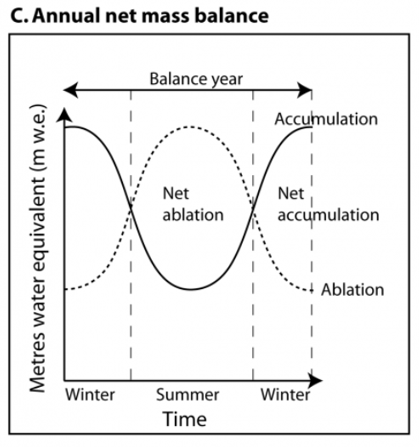


We will start off with the time series evaluation of the spectral characteristics of snow using NDSI (Normalized Difference Snow Index) using the time series' highest and lowest peak.

___

## 4: Import AOI shapefile into GEE asset.

First we will upload our area of interest into GEE asset. In case you have error message _No Module named pycrs_, run this code in a new cell `py install pycrs`.

In [ ]:
aoi = geemap.shp_to_ee(r'/content/drive/MyDrive/Day6_Practical/aoi.shp')

In [ ]:
# Let's see our metadata of aoi. AOI is now termed as Feature Collection.
display(aoi)

## 5: we're going to use Landsat image collection and three years of time-span (2019, 2020, 2021)

In [ ]:
col = ee.ImageCollection("NASA/HLS/HLSL30/v002") # Harmonized Landsat Image
elevation = ee.Image("CGIAR/SRTM90_V4").clip(aoi) # SRTM elevation

start =  ee.Date('2019-01-01')
end = ee.Date('2021-12-31')

The band list of the selected image collection are as follows. Note that the band names for image collections will have different names. So, make sure you change your band names according to the band description.

|Band Name|Description|
|---|---|
|B1|Coastal Aerosol|
|B2|Blue|
|B3|Green|
|B4|Red|
|B5|NIR|
|B6|SWIR1|
|B7|SWIR2|
|B9|Cirrus|
|B10|TIRS1 (Thermal Infrared)|
|B11|TIRS2 (Thermal Infrared)|

In [ ]:
band = ['B1','B2','B3','B4','B5','B6','B7', 'B8', 'B9', 'B10', 'B11']

# filter our image collection based on bands and area of interest.
col = col.filterDate(start, end).filterBounds(aoi)

Let's check out the metadata of our landsat collection

In [ ]:
# Let's see what kind of metadata landsat single ee.image has to offer.
# Note that the bands are already surface reflectances and brightness temperatures.
# Therefore, you don't need to convert fron digital number to surface reflectance.
display(col.limit(10))
display(col.size())

## 6: Now, we're calculating the NDSI with the preprocessed image collection.

$NDSI = \frac{Green - SWIR}{Green+SWIR}$

In this case, Green is B3, SWIR is B6. The equation will be the same, but if the collection is different, the band names will be different. Modify accordingly.



In [ ]:
# function to calculate NDSI
def ndsicalc(img):
  # clipping into area of interest
  image = img.clip(aoi)

  # apply quality masking
  fmask = image.select('Fmask')

  # bitmask
  cloud = ee.Image(fmask.bitwiseAnd(1 << 1).eq(0))
  shadow = ee.Image(fmask.bitwiseAnd(1 << 3).eq(0)
)
  # Combine: keep only clear land (no cloud, shadow, snow, or water)
  clear = cloud.And(shadow)

  image2 = image.updateMask(clear)

  ndsi = image2.normalizedDifference([band[2], band[5]]).rename('ndsi')
  return ee.Image(ndsi.copyProperties(img, ['system:time_start']))

In [ ]:
ndsi_col = col.map(ndsicalc)

Let's check out the NDSI image collection

In [ ]:
display(ndsi_col.limit(10))

display(ndsi_col.size())

Mosaicing images of the same date

In [ ]:
def mergebyDate(imcol):

  # from image collection to a list
  imglist = imcol.toList(imcol.size())

  # driver function
  def uniquedate(img):
    return ee.Image(img).date().format('YYYY-MM-dd');

  # applying driver function
  uniquedates = imglist.map(uniquedate).distinct()

  # driver function for mapping the mosaics based on unique dates
  def mosaicDriver(dateid):
    id = ee.Date(dateid)

    image = (imcol.filterDate(id, id.advance(1, 'day'))).mosaic()
    return image.set(
        {'system:time_start': id.millis(),
        'system:id': id.format('YYYY-MM-dd')});

  mosaicImglist = uniquedates.map(mosaicDriver)

  return ee.ImageCollection(mosaicImglist)

In [ ]:
ndsi_mosaic = mergebyDate(ndsi_col)

# Let's see the results
display(ndsi_mosaic)
display(ndsi_mosaic.size())

## 7: Next, we're visualize the time series pattern of NDSI.

In [ ]:
def extractNDSItime(img):
  ndsi = img.select('ndsi')

  # Here, we're using the median
  mean = ndsi.reduceRegion(reducer = ee.Reducer.median(),
                           geometry = aoi,
                           scale = 30)
  val = mean.get('ndsi')

  return img.set('DateDict', img.date().format()).set('ndsi', val)

In [ ]:
timeseries = ndsi_mosaic.map(extractNDSItime)

In [ ]:
display(timeseries.limit(10))

We will use two lists in image collection to pandas dataframe.

In [ ]:
nested_list = timeseries.reduceColumns(ee.Reducer.toList(2), ['DateDict', 'ndsi']).values().get(0)

We will get the nested list into pandas dataframe, and small formatting to workable excel sheet.

In [ ]:
df =pd.DataFrame(nested_list.getInfo(), columns=['DateDict', 'ndsi'])
df['DateDict'] = pd.to_datetime(df['DateDict'])
df = df.set_index('DateDict')

In [ ]:
df

,ndsi
DateDict,
2019-01-14,0.915932
2019-02-15,0.840116
2019-03-03,0.910135
2019-03-19,0.857463
2019-04-04,0.894638
...,...
2021-11-12,0.941497
2021-11-19,0.946251
2021-12-05,0.948344


Plotting the time series of NDSI for three years.

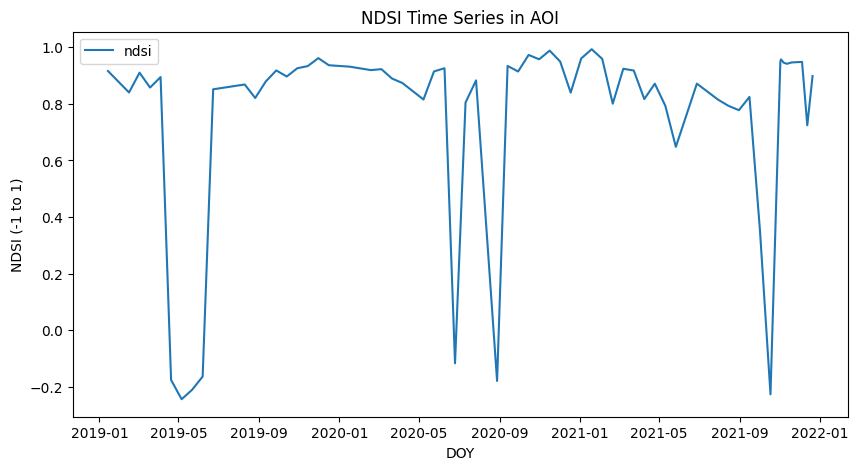

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df, ax = ax)

ax.set_ylabel('NDSI (-1 to 1)', fontsize = 10)
ax.set_xlabel('DOY', fontsize = 10)
ax.set_title('NDSI Time Series in AOI', fontsize = 12)
plt.show()

From here, we observed two cycles of NDSI, indicating two accumulation period and two ablation period from general perspective. The first cycle of accumulation from last year December until next July as one cycle; and July to December as another cycle.

Note that the start date of acumulation means end date of last cycle's ablation. And the start date of ablation means end date of last cycle's accumulation. When we analyze the glacier boundaries, ELA, the date selection steps are done from this time series of satellite imagery. After that we delineate the contact boundary of the glacier extent and record all the data in time series manner in order to achieve the glacier monitoring.

Saving the NDSI Time Series as Excel Sheets

In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/Day6_Practical/NDSI_timeseries_2019-2021.xlsx', engine = 'openpyxl')

df.to_excel(writer, sheet_name = 'NDSI')
writer.close()

From the excel sheet, we now know that the natural cycle of mass balance in this area is estimated to be two year, first year in accumulation, and 2nd year in ablation. From this, we have the first image of the accumulation year and the last image of the ablation year; which is how we select the satellite images to estimate the parameters of the glaciers.

In [ ]:
# firstdate = ee.Date('2016-01-06') # first image of the accumulation year
# lastdate = ee.Date('2017-12-26') # the last image of the ablation year

firstdate = ee.Date('2020-09-13') # first image of the accumulation year
lastdate = ee.Date('2021-09-16') # the last image of the ablation year

In [ ]:
firstimg = col.filterDate(firstdate, firstdate.advance(1, 'day')).first().clip(aoi)
lastimg = col.filterDate(lastdate, lastdate.advance(1, 'day')).first().clip(aoi)

display(firstimg)
display(lastimg)

## 8: We now know the dates of images. Let's visualize the results in the map interface

In [ ]:
basemap = geemap.Map(center = [28.197, 90.25], zoom = 10.5)
basemap.add_draw_control()

# visualization settings in map
params = {'bands': ['B7', 'B5', 'B3'], 'gamma': 1.0, 'min': 0.12, 'max': 1.0}

# adding area of interest and the two selected images
basemap.addLayer(aoi, {'color': 'blue', 'opacity': 0.5}, 'Area of Interest')
basemap.addLayer(firstimg, params,'2020Ablation')
basemap.addLayer(lastimg, params,'2021Ablation')
basemap.addLayer(elevation, {}, 'Elevation')


In [ ]:
basemap

Map(center=[28.197, 90.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataG…

<IPython.core.display.Javascript object>

vis_params = {'bands': ['B4', 'B3', 'B2'], 'gamma': 1.0, 'min': 0.12, 'max': 1.0}


Saving two ELA lines from two years. You have to draw each ELA line individually and save it as Feature Collection.

_Note: Draw the snow line of the first image first; secondly save it as feature collection, and delete the feature in the interactive map, and repeat. You will have two snowlines representing the ELA for each cycle's end._

In [ ]:
# for 2021
f1 = ee.FeatureCollection(basemap.draw_features)

display(f1)

In [ ]:
# for 2020
f2 = ee.FeatureCollection(basemap.draw_features)

display(f2)

Adding the two lines in the Map

In [ ]:
basemap.addLayer(f1, {'color': 'blue'}, '2021Snowline')
basemap.addLayer(f2, {'color': 'red'}, '2020Snowline')

In [ ]:
basemap

## 9: After receiving the two snowlines, we're extracting the elevations from those line to become ELA.

First, we will create buffer zone of 30 meters (since Landsat image is 30 meters resolution).

The created buffer zones will be applied to extract the elevation.

In [ ]:
basemap.addLayer(bufferELA2021, {'color': 'blue'}, 'buffer')
basemap.addLayer(bufferELA2020, {'color': 'red'}, 'buffer2')

In [ ]:
# create a buffer zone
bufferELA2020 = ee.Feature(f2.first()).buffer(30)

# sample the elevation value along the line using reduceRegions
sampledELA2020 = elevation.reduceRegions(
    collection = bufferELA2020,
    reducer = ee.Reducer.mean(),
    scale = 30
)

display(sampledELA2020)

# create a buffer zone
bufferELA2021 = ee.Feature(f1.first()).buffer(30)

# sample the elevation value along the line using reduceRegions
sampledELA2021 = elevation.reduceRegions(
    collection = bufferELA2021 ,
    reducer = ee.Reducer.mean(),
    scale = 30
)

display(sampledELA2021)

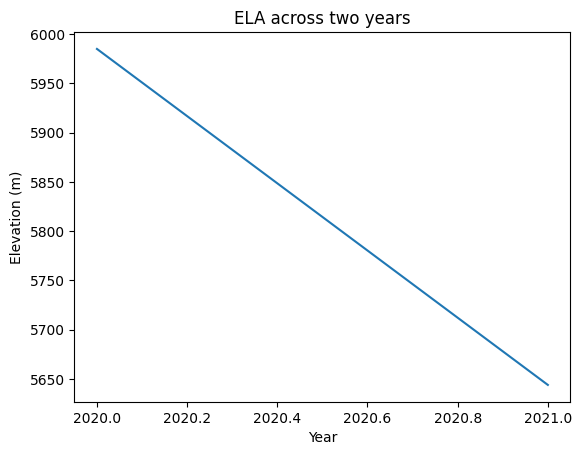

In [ ]:
# Get the elevation extraction
elev_list = [sampledELA2020.first().toDictionary().getInfo()['mean'],
             sampledELA2021.first().toDictionary().getInfo()['mean']]

year = [2020, 2021]

plt.plot(year, elev_list)
plt.xlabel('Year')
plt.ylabel('Elevation (m)')
plt.title('ELA across two years')
plt.show()

ELA goes from high elevation to low elevation. Ablation characteristics is detected.

##  10: Save the two vectors of snow lines into shapefile in Google Drive

In [ ]:
# geemap.ee_export_vector_to_drive(collection = sampledELA2020, folder = 'Bhutan_2nd_training', file_format='shp')
# geemap.ee_export_vector_to_drive(collection = sampledELA2021, folder = 'Bhutan_2nd_training', file_format='shp')
task1 = ee.batch.Export.table.toDrive(
    collection= sampledELA2020,
    description= '2020Snowline',
    folder= 'Bhutan_2nd_training',
    fileFormat= 'SHP'
)
task1.start()

task2 = ee.batch.Export.table.toDrive(
    collection= sampledELA2021,
    description= '2021Snowline',
    folder= 'Bhutan_2nd_training',
    fileFormat= 'SHP'
)
task2.start()

## 11: We will save two images: 2020Ablation and 2021Ablation

In [ ]:
# filter the bands for atmospheric penetration (by Landsat 8)
firstimg2 = firstimg.select(['B7', 'B5', 'B3'])
lastimg2 = lastimg.select(['B7', 'B5', 'B3'])

display(firstimg2)
display(lastimg2)

In [ ]:
task = ee.batch.Export.image.toDrive(
    image= firstimg2,
    description='2020Ablation',
    folder='Day6_Practical',
    region= aoi.geometry(),
    scale=30,
    crs='EPSG:32646'
)
task.start()
task2 = ee.batch.Export.image.toDrive(
    image= lastimg2,
    description='2021Ablation',
    folder='Day6_Practical',
    region=aoi.geometry(),
    scale=30,
    crs='EPSG:32646'
)
task2.start()
# geemap.ee_export_image_to_drive(firstimg, '2020Ablation', folder=r'Bhutan_2nd_training',
#                          region=aoi.geometry(), scale=30, crs='EPSG:4326')
# geemap.ee_export_image_to_drive(lastimg, '2021Ablation', folder=r'Bhutan_2nd_training',
#                          region=aoi.geometry, scale=30, crs='EPSG:4326')

You can see that the ELA line is detected at the end of the summer period for every natural glacier cycle by 1.86 km. By satellite imagery,the glacier from 2020 to 2021 is in accumulation cycle period (+mass balance).
___
END of Practical 1
___
